In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import math
import random
import os
import time

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from utils import read_images, augment_gpu, augment_easy, random_picture, pictures_per_year, graph
from inception_preprocessing import preprocess_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

random.seed(1)

# TensoBoard util
def TB(dir, cleanup=False):
    import webbrowser
    webbrowser.open('http://127.0.1.1:6006')

    !tensorboard --logdir=dir

    #if cleanup:
    #    !rm -R logs/

## Bilder lesen, resizing und export numpy

In [2]:
# Konstanten für Input Pipeline
PATH = "C:\\Users\\Toem\\Desktop\\BA\\Datensets\\Bilder-nach-Baujahren"
PATH_MODELS = "C:\\Users\\Toem\\Desktop\\BA\\Models"
TEST_TO_TRAIN_RATIO = 0.15
CPUS = 8
NUM_CLASSES = 1
IMG_HEIGHT = 240
IMG_WIDTH = 240
CHANNELS = 3

1708 Bilder einzulesen dauerte 102.07 Sekunden.
X: (1708, 240, 240, 3)
Y: (1708, 1)


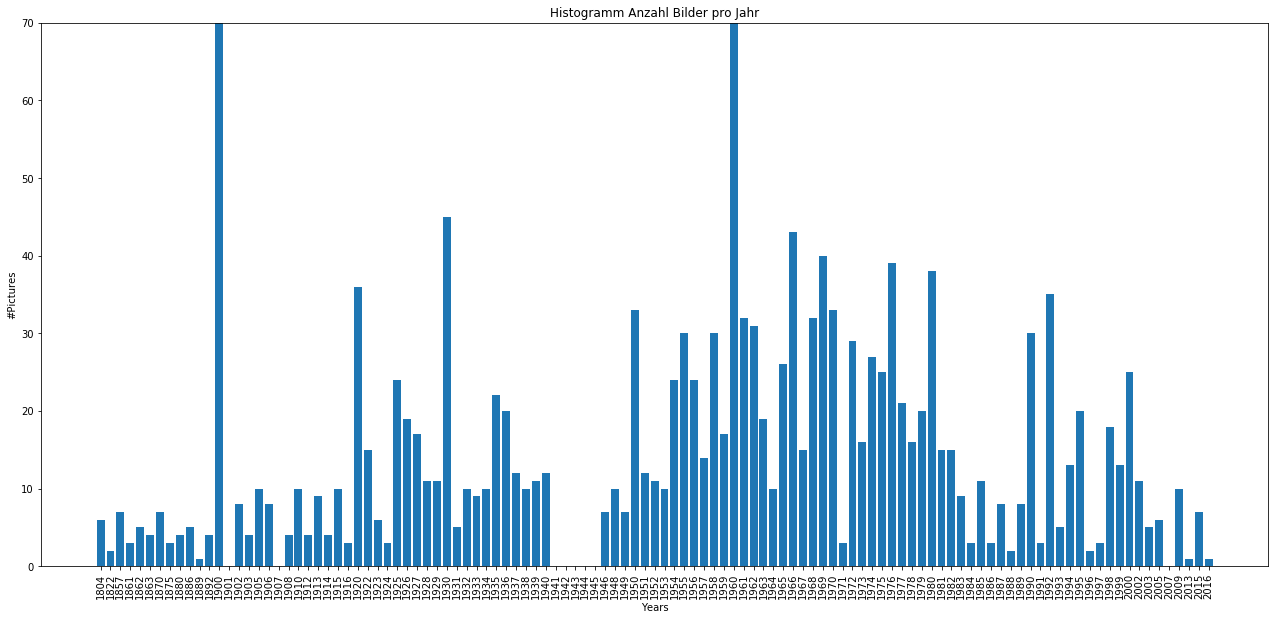

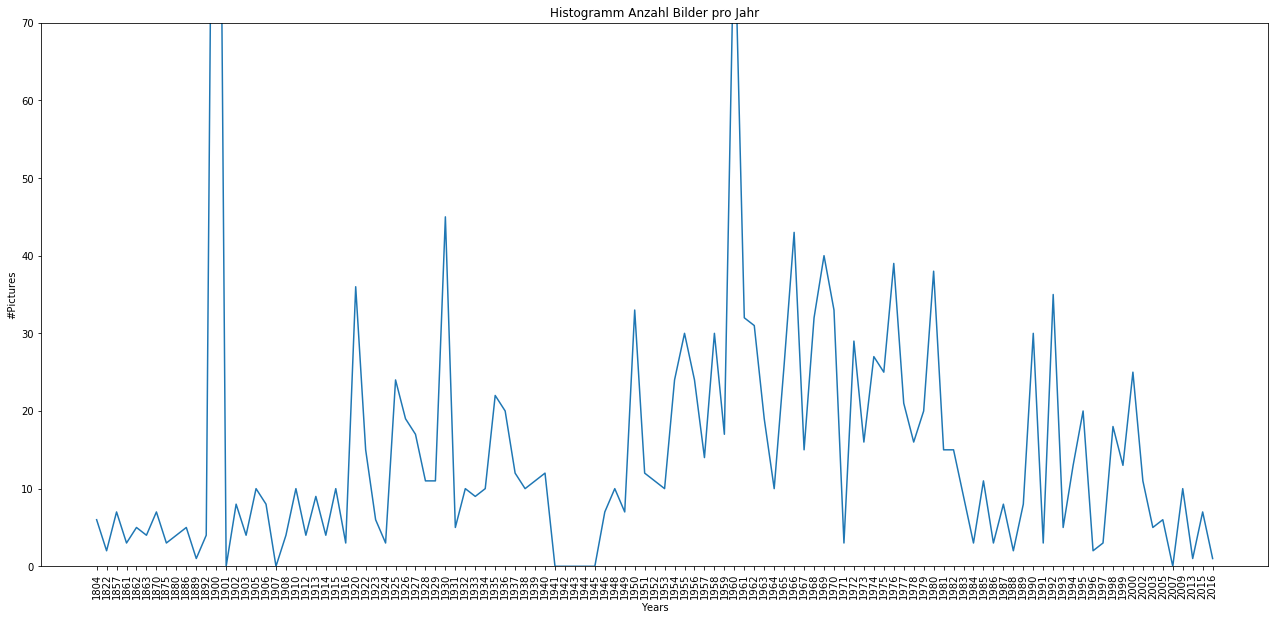

In [3]:
X, Y = read_images(PATH, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

In [4]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=TEST_TO_TRAIN_RATIO)

trainX = trainX / 255
testX = testX / 255

del X
del Y

print("Dimension of trainX: " + str(trainX.shape))
print("Dimension of trainY: " + str(trainY.shape))
print("Dimension of testX: " + str(testX.shape))
print("Dimension of testY: " + str(testY.shape))

Dimension of trainX: (1451, 240, 240, 3)
Dimension of trainY: (1451, 1)
Dimension of testX: (257, 240, 240, 3)
Dimension of testY: (257, 1)


Random picture trainX
Baujahr: [1974], Index: 275


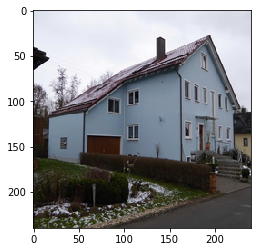

In [5]:
print("Random picture trainX")
random_picture(trainX, trainY)

Random picture testX
Baujahr: [1958], Index: 32


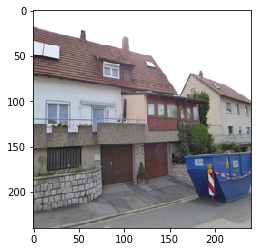

In [6]:
print("Random picture testX")
random_picture(testX, testY)

## TensorFlow Initialisierung Variablen und DataSet

In [5]:
def initialize_placeholders():
    # TF Hyperparameter
    batch_size = tf.placeholder(tf.int64)
    pkeep = tf.placeholder(tf.float32)
    
    # TF Inputvariablen für Dataset
    x = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    y = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])
    
     # TF sonstige Parameter
    i = tf.placeholder(tf.int32)
    testing = tf.placeholder(tf.bool)
    
    return x, y, batch_size, pkeep, i, testing

def initialize_variables(c1, c2, c3, fc, patch1=6, patch2=5, patch3=4, bias_init=0.01, std=0.1):
    # TF Netzwerkparameter (weights und biases)
    W1 = tf.Variable(tf.truncated_normal([patch1, patch1, CHANNELS, c1], stddev=std))
    B1 = tf.Variable(tf.constant(bias_init, tf.float32, [c1]))            
    W2 = tf.Variable(tf.truncated_normal([patch2, patch2, c1, c2], stddev=std))
    B2 = tf.Variable(tf.constant(bias_init, tf.float32, [c2]))
    W3 = tf.Variable(tf.truncated_normal([patch3, patch3, c2, c3], stddev=std))
    B3 = tf.Variable(tf.constant(bias_init, tf.float32, [c3]))

    W4 = tf.Variable(tf.truncated_normal([int(IMG_HEIGHT/4) * int(IMG_HEIGHT/4) * c3, fc], stddev=std))
    B4 = tf.Variable(tf.constant(bias_init, tf.float32, [fc]))

    W5 = tf.Variable(tf.truncated_normal([fc, NUM_CLASSES], stddev=std))
    B5 = tf.Variable(tf.constant(bias_init, tf.float32, [NUM_CLASSES]))

    parameters = {"W1": W1, "B1": B1, "W2": W2, "B2": B2, "W3": W3, "B3": B3, "W4": W4, "B4": B4, "W5": W5, "B5": B5}
    
    return parameters
    

def initialize_datasets(x, y, examples_train, examples_test, epochs, batch_size, augmentation=None):
    dataset_train = tf.data.Dataset.from_tensor_slices((x, y))
    dataset_train = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=examples_train, count=epochs))
    dataset_train = dataset_train.batch(batch_size)
    
    if augmentation != None:
        dataset_train = dataset_train.map(input_parser(augmentation, num_parallel_calls=CPUS))

    dataset_test = tf.data.Dataset.from_tensor_slices((x, y))
    dataset_test = dataset_test.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=examples_test, count=-1))
    dataset_test = dataset_test.batch(batch_size)

    # Iterator 
    iterator_train = dataset_train.make_initializable_iterator()
    iterator_test = dataset_test.make_initializable_iterator()

    
    return iterator_train, iterator_test   
    

## Data augmentation

In [6]:
# Data augmentation, 4-D Tensor input
def input_parser(images, labels, augment="augment_easy"):
    
    if method == "augment_gpu":
        augmented_images, labels = augment_gpu(images, labels, horizontal_flip=False, vertical_flip=True, rotate=0, crop_probability=0.3)
    
    if method == "augment_easy":
        augmented_images, labels = augment_easy(images, labels)
    
    if method == "augment_inception":
        augmented_images = tf.map_fn(lambda img: preprocess_image(img, height=IMG_HEIGHT, width=IMG_WIDTH, is_training=True), images)
    
    
    return augmented_images, labels

In [7]:
def get_input_batch_data(testing, iterator_train, iterator_test):
    features, labels = tf.cond(testing, lambda: iterator_test.get_next(), lambda: iterator_train.get_next())
    return features, labels

## Batchnorm

In [8]:
def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()

## Netzwerkarchitektur

In [9]:
def forward_pass(features, labels, parameters, pkeep, i, testing):
    # CONV Layer 1
    stride = 1
    A1l = tf.nn.conv2d(features, parameters["W1"], strides=[1, stride, stride, 1], padding="SAME")
    A1bn, update_ema1 = no_batchnorm(A1l, testing, i, parameters["B1"], convolutional=True)
    A1 = tf.nn.relu(A1bn)

    # Conv Layer 2
    stride = 2
    A2l = tf.nn.conv2d(A1, parameters["W2"], strides=[1, stride, stride, 1], padding="SAME")
    A2bn, update_ema2 = no_batchnorm(A2l, testing, i, parameters["B2"], convolutional=True)
    A2 = tf.nn.relu(A2bn)

    # Conv Layer 3
    stride = 2
    A3l = tf.nn.conv2d(A2, parameters["W3"], strides=[1, stride, stride, 1], padding="SAME")
    A3bn, update_ema3 = no_batchnorm(A3l, testing, i, parameters["B3"], convolutional=True)
    A3 = tf.nn.relu(A3bn)

    # Flatten Layer 3
    # A3 = tf.reshape(A3, shape=[-1, int(IMG_HEIGHT/4) * int(IMG_HEIGHT/4) * CONV_LAYER3])
    A3 = tf.contrib.layers.flatten(A3)

    # FC Layer 4
    A4l = tf.matmul(A3, parameters["W4"]) + parameters["B4"]
    A4bn, update_ema4 = no_batchnorm(A4l, testing, i, parameters["B4"])
    A4 = tf.nn.relu(A4bn)

    # Dropout Layer 5
    A4 = tf.nn.dropout(A4, pkeep) 

    # FC Layer 6
    Ypreds = tf.matmul(A4, parameters["W5"]) + parameters["B5"]
    
    return Ypreds

## Modell

In [10]:
def model(layer1=12, layer2=24, layer3=48, fclayer=200, epochs=100, batchsize=16, bn=False, p_keep=0.5, 
          init_lr=0.02, decayed_lr=0.0001, decay_steps=1600, augmentation=None):
    
    NUM_EXAMPLES_TRAIN = len(trainX)
    NUM_EXAMPLES_TEST = len(testX)
    NUM_BATCHES = NUM_EXAMPLES_TRAIN // batchsize
    
    print("NUM_EXAMPLES_TRAIN: " + str(NUM_EXAMPLES_TRAIN))
    print("NUM_EXAMPLES_TEST: " + str(NUM_EXAMPLES_TEST))
    print("NUM_BATCHES: " + str(NUM_BATCHES))
    
    epoch_losses_train = list()
    epoch_losses_test = list()
    epoch_elapsed_times = list()
    
    # 1) initialize variables
    x, y, batch_size, pkeep, i, testing = initialize_placeholders()
    parameters = initialize_variables(layer1, layer2, layer3, fclayer, patch1=6, patch2=5, patch3=4, bias_init=0.01, std=0.1)
    
    # 2) init datasets
    iterator_train, iterator_test = initialize_datasets(x, y, NUM_EXAMPLES_TRAIN, NUM_EXAMPLES_TEST, epochs, batchsize, augmentation)
    
    # 3) input batch for forward pass
    features, labels = get_input_batch_data(testing, iterator_train, iterator_test)
    
    # 4) forward pass
    Ypreds = forward_pass(features, labels, parameters, pkeep, i, testing)
    
    # 5) loss
    # loss = tf.losses.mean_squared_error(predictions=Ypreds, labels=labels)
    # update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)
    # loss = tf.reduce_mean(tf.squared_difference(Ypreds, labels))
    loss = tf.losses.mean_squared_error(predictions=Ypreds, 
                                        labels=labels, 
                                        reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)
    #tf.summary.scalar("loss", loss)
    
    # 6) train step
    lr = init_lr + tf.train.exponential_decay(decayed_lr, i, decay_steps, 1/math.e)
    #tf.summary.scalar("learning_rate", lr)
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    
    # 6.5) Tensorboard
    #merged = tf.summary.merge_all()
    
    # 7) Loop over epochs, batches
    with tf.Session() as sess:
        # init global variables
        sess.run(tf.global_variables_initializer())
        
        # Tensorboard init
        #train_writer = tf.summary.FileWriter(PATH_MODELS + "/train", graph=tf.get_default_graph())
       # test_writer = tf.summary.FileWriter(PATH_MODELS + "/test")
        
        # initialise with train data
        sess.run(iterator_train.initializer, feed_dict={x: trainX, y: trainY, batch_size: batchsize})
        
        # initialise with test data
        sess.run(iterator_test.initializer, feed_dict={x: testX, y: testY, batch_size: NUM_EXAMPLES_TEST})

  
        for j in range(epochs):
        
            tic = time.time()
            epoch_train_loss = 0
            
            for k in range(NUM_BATCHES):
                iters_total = j*NUM_BATCHES + k

                # training
                _, batch_loss = sess.run([train_step, loss], feed_dict={testing: False, i: iters_total, pkeep: p_keep})
                
                # testing
                # test loss nach 1 epoch
                
                epoch_test_loss = sess.run(loss, feed_dict={testing: True, i: iters_total, pkeep: 1})
                if not np.isnan(epoch_test_loss):
                    epoch_losses_test.append(epoch_test_loss / NUM_BATCHES)
                
                if not np.isnan(batch_loss):
                    epoch_losses_train.append(batch_loss / NUM_BATCHES)
                #train_writer.add_summary(summary, iters_total)

                
          
            
            # train loss after 1 batch
            # epoch_losses_train.append(epoch_train_loss)

            # time
            toc = time.time()
            epoch_elapsed = toc-tic
            epoch_elapsed_times.append(epoch_elapsed)
            


            # logging
            print("Iter: %d, Epoch: %d (%.2fs), Train-Loss: %.2f, Test-Loss: %.2f" % (
                                                iters_total, j, epoch_elapsed, 
                                                np.mean(epoch_losses_train), 
                                                np.mean(epoch_losses_test)))
 
            

        print("Dauer insgesamt: %.2f, Average Time per Epoch: %.2f" % (sum(epoch_elapsed_times), 
                                                                       (sum(epoch_elapsed_times) / float(len(epoch_elapsed_times)))))
        graph(epoch_losses_train, epoch_losses_test)
    
    
    

## Auswertung

NUM_EXAMPLES_TRAIN: 1451
NUM_EXAMPLES_TEST: 257
NUM_BATCHES: 45
Instructions for updating:
Use the retry module or similar alternatives.
Iter: 44, Epoch: 0 (8.46s), Train-Loss: 103011.18, Test-Loss: 100162.34
Iter: 89, Epoch: 1 (4.17s), Train-Loss: 93699.51, Test-Loss: 92130.21
Iter: 134, Epoch: 2 (4.13s), Train-Loss: 90217.82, Test-Loss: 88978.74
Iter: 179, Epoch: 3 (4.14s), Train-Loss: 88503.13, Test-Loss: 87515.81
Iter: 224, Epoch: 4 (4.18s), Train-Loss: 87336.62, Test-Loss: 86486.40
Iter: 269, Epoch: 5 (4.10s), Train-Loss: 86388.38, Test-Loss: 85637.64
Iter: 314, Epoch: 6 (4.14s), Train-Loss: 85534.52, Test-Loss: 84858.43
Iter: 359, Epoch: 7 (4.29s), Train-Loss: 84693.19, Test-Loss: 84074.78
Iter: 404, Epoch: 8 (4.20s), Train-Loss: 83973.64, Test-Loss: 83314.47
Iter: 449, Epoch: 9 (4.40s), Train-Loss: 83149.73, Test-Loss: 82541.73
Iter: 494, Epoch: 10 (4.17s), Train-Loss: 82297.66, Test-Loss: 81728.20
Iter: 539, Epoch: 11 (4.17s), Train-Loss: 81401.84, Test-Loss: 80856.41
Iter: 584

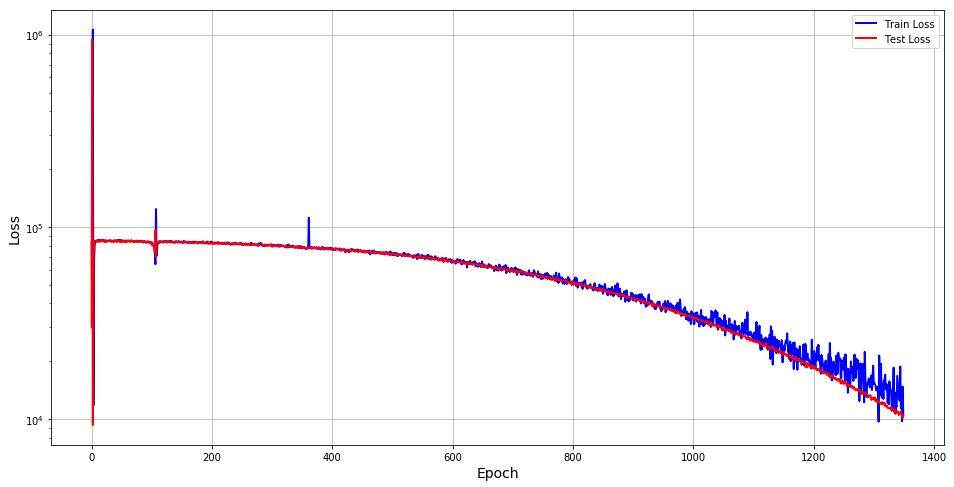

In [11]:
model(layer1=6, layer2=12, layer3=24, fclayer=100, epochs=30, batchsize=32, bn=False, p_keep=0.70, 
          init_lr=0.01, decayed_lr=0.001, decay_steps=1600, augmentation=None)